<h1>Image colorization using a U-NET Neural Network</h1>

In [1]:
from tqdm import tqdm
import tensorflow as tf
import colorizerutils as utils
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import initializers

<p style='color:red'>This VRAM limit is necessary because of my atypical hardware setup. You may need to remove or edit this to your desired VRAM usage limit.</p>

In [2]:
# The amount of GPU memory to allocate to Tensorflow
vram = 14 # GB

gpus = tf.config.list_physical_devices('GPU')

tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=vram*1024)])

tf.__version__

'2.8.0'

In [3]:
# Creates a dataset using images from ../images/train_images/
train_dataset = tf.data.Dataset.from_generator(
    utils.image_loader,
    output_types=(tf.float32,tf.float32)
)

# Directory for tensorboard logs
log_directory = 'logs/'

# Set up tensorboard logging for the generator loss
summary_writer = tf.summary.create_file_writer(log_directory + 'mse_colorizer/')
gen_loss_tracker = metrics.Mean('Generator_mse_loss',dtype=tf.float32)

<h1>Neural Network Structure</h1><br>
The colorizer uses a single modified U-NET neural network. The structure of the generator is pictured below.

In [4]:
# Downsampling block for use in U-NET
def downsampling(filters,stride,prev_layer):

    init = initializers.RandomNormal()

    block = layers.Conv2D(filters,strides=stride,kernel_size=4,padding='same',kernel_initializer=init,use_bias=False)(prev_layer)
    block = layers.BatchNormalization()(block)
    block = layers.LeakyReLU(0.2)(block)

    return block

# Upsampling block for use in U-NET
# Skip layer should be the same shape as the output to the transpose convolutional layer
# Or twice the size of the prev_layer input
def upsampling(filters,stride,prev_layer,skip_layer):

    init = initializers.RandomNormal()

    block = layers.Conv2DTranspose(
        filters,strides=stride,kernel_size=4,padding='same',kernel_initializer=init,use_bias=False)(prev_layer)
    block = layers.BatchNormalization()(block)
    block = layers.Concatenate()([block,skip_layer])
    block = layers.LeakyReLU(0.2)(block)
    block = layers.Dropout(0.3)(block)

    return block

<center><img src=resources/generator_arch.png></center>

In [5]:
def make_generator():

    init = initializers.RandomNormal()

    # Model input is a (64x64) grayscale image
    model_input = layers.Input(shape=(64,64,1))

    # Downsampling stack
    down0 = downsampling(filters=32,stride=1,prev_layer=model_input) # (64x64) -> (64x64)
    down1 = downsampling(64,2,down0) # (64x64) -> (32x32)
    down2 = downsampling(128,2,down1) # (32x32) -> (16x16)
    down3 = downsampling(256,2,down2) # (16x16) -> (8x8)
    down4 = downsampling(256,2,down3) # (8x8) -> (4x4)
    down5 = downsampling(256,2,down4) # (4x4) -> (2x2)
    down6 = downsampling(256,2,down5) # (2x2) -> (1x1)


    # Upsampling stack
    up5 = upsampling(filters=256,stride=2,prev_layer=down6,skip_layer=down5) # (1x1) -> (2x2)
    up4 = upsampling(256,2,up5,down4) # (2x2) -> (4x4)
    up3 = upsampling(256,2,up4,down3) # (4x4) -> (8x8)
    up2 = upsampling(128,2,up3,down2) # (8x8) -> (16x16)
    up1 = upsampling(64,2,up2,down1) # (16x16) -> (32x32)
    up0 = upsampling(32,2,up1,down0) # (32x32) -> (64x64)
    
    # Model output is (64x64) with 2 color channels with values between -1 and 1
    model_output = layers.Conv2DTranspose(
        2,strides=1,kernel_size=4,padding='same',activation='tanh',kernel_initializer=init,use_bias=False)(up0)

    model = keras.models.Model(model_input,model_output)
    return model

In [6]:
def generator_loss(generator_output,color_channels):

    # Loss is the mean squared difference between the generated images
    # and the original colored images
    mse = losses.MeanSquaredError()
    mse_loss = mse(generator_output,color_channels) 

    return mse_loss

In [7]:
# Create the generator and generator optimizer
generator = make_generator()

# Beta1 to decrease importance of previous batches
generator_optimizer = optimizers.Adam(2e-4,beta_1=0.5)
generator.compile()
generator.summary()
#keras.utils.plot_model(generator,show_shapes=True,to_file='generator.png',dpi=48)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   512         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['batch_normalization[0][0]']

<h1>Model Training Loop</h1><br>
This will train the model using all available training images and save the training results as a tensorboard log. The fully trained generator is also saved.<br><br>
<center><img src=resources/Gen_MSE_Training.png></center>

In [8]:
@tf.function
def train_step(gray_channel,color_channels):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # Generate a batch of fake images
        generator_output = generator(gray_channel,training=True)

        # Calculate loss for generator and discriminator based on discriminator outputs
        gen_loss = generator_loss(generator_output,color_channels)

    # Calculate generator gradients and train generator
    generator_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))

    # Update tensorboard losses
    gen_loss_tracker(gen_loss)

In [9]:
def train_model(epochs,dataset):
    
    step_counter = 0

    # Progress bar/tracking
    for _ in tqdm(range(epochs)):

        for gray_channel,color_channels in dataset:
            train_step(gray_channel,color_channels)

            # Tensorboard logging for training
            with summary_writer.as_default():
                tf.summary.scalar('Generator_mse_loss',gen_loss_tracker.result(),step=step_counter)
            
            gen_loss_tracker.reset_states()
            step_counter += 1

In [10]:
train_model(epochs=500,dataset=train_dataset)
generator.save('models/mse/generator.h5')

100%|███████████████████████████████████████| 500/500 [1:41:09<00:00, 12.14s/it]


<h1>Training Set Results</h1>

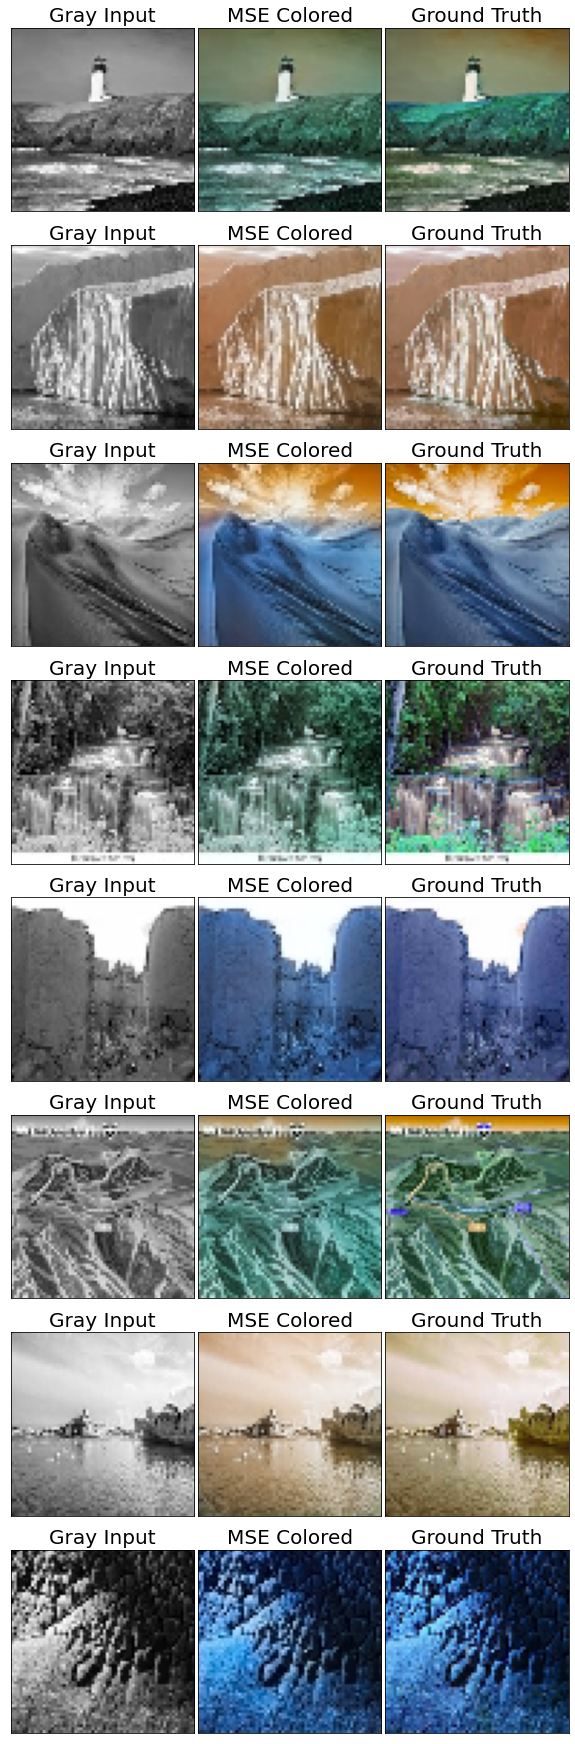

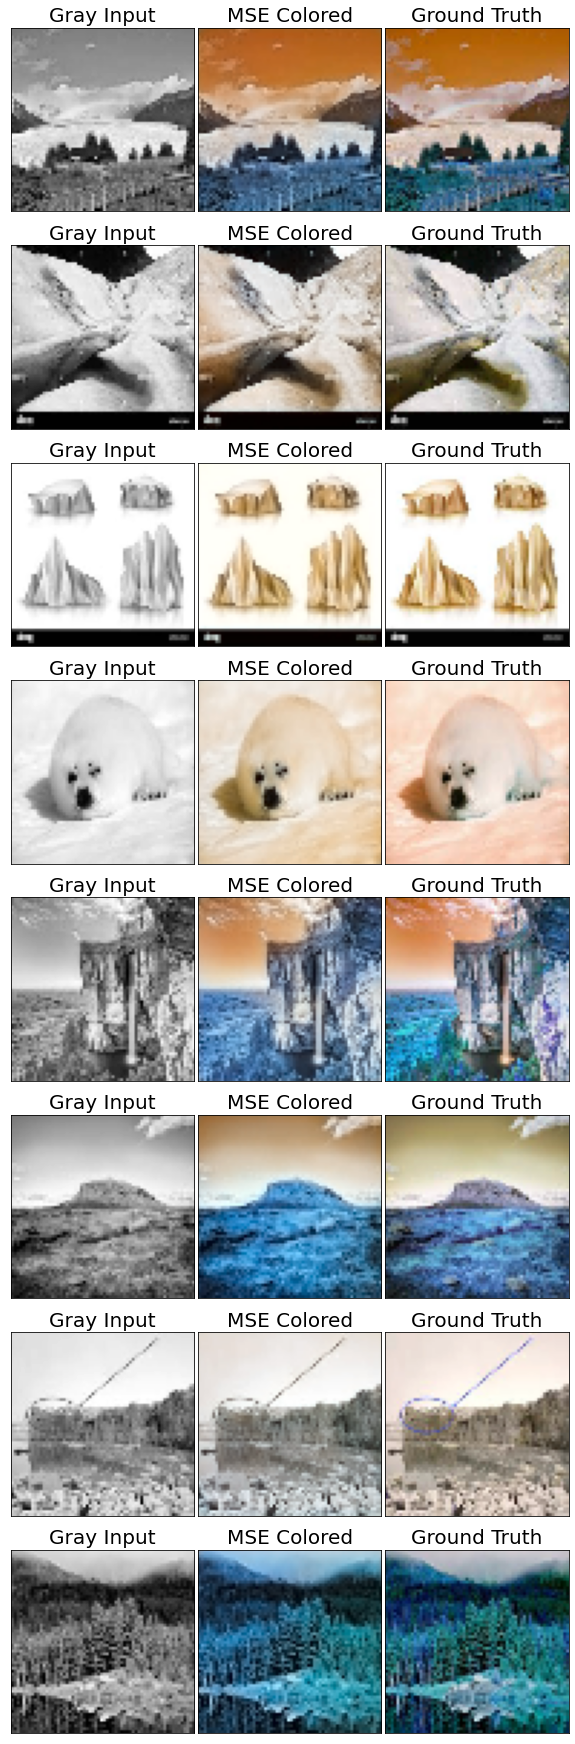

In [11]:
# Show results for batches of the training set
for train_batch in range(2):
    train_images = utils.image_loader(directory='../images/train_images/',
        batch_size=8,training=False).__getitem__(train_batch)
    utils.display_images(gray_channel=train_images[0],color_channels=train_images[1],generator1=generator,gen1_title='MSE Colored');

<h1>Validation Set Results</h1>

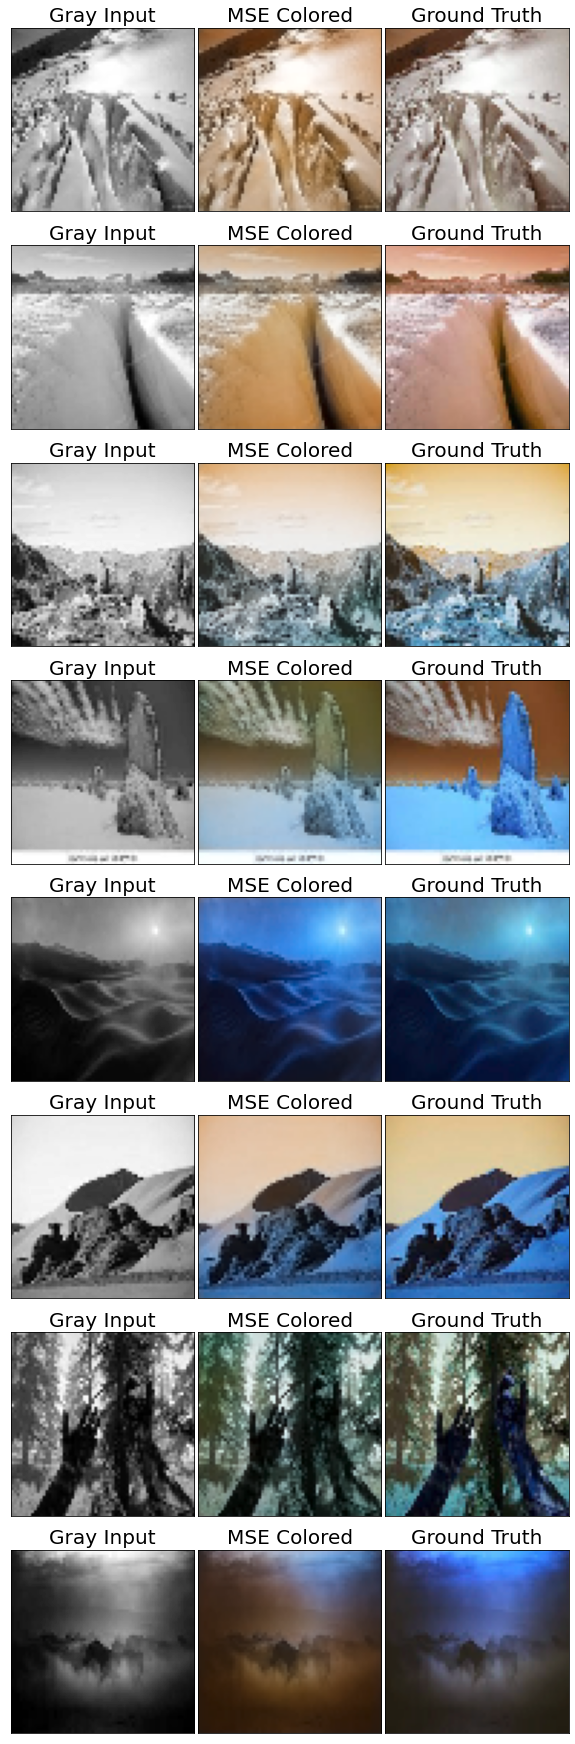

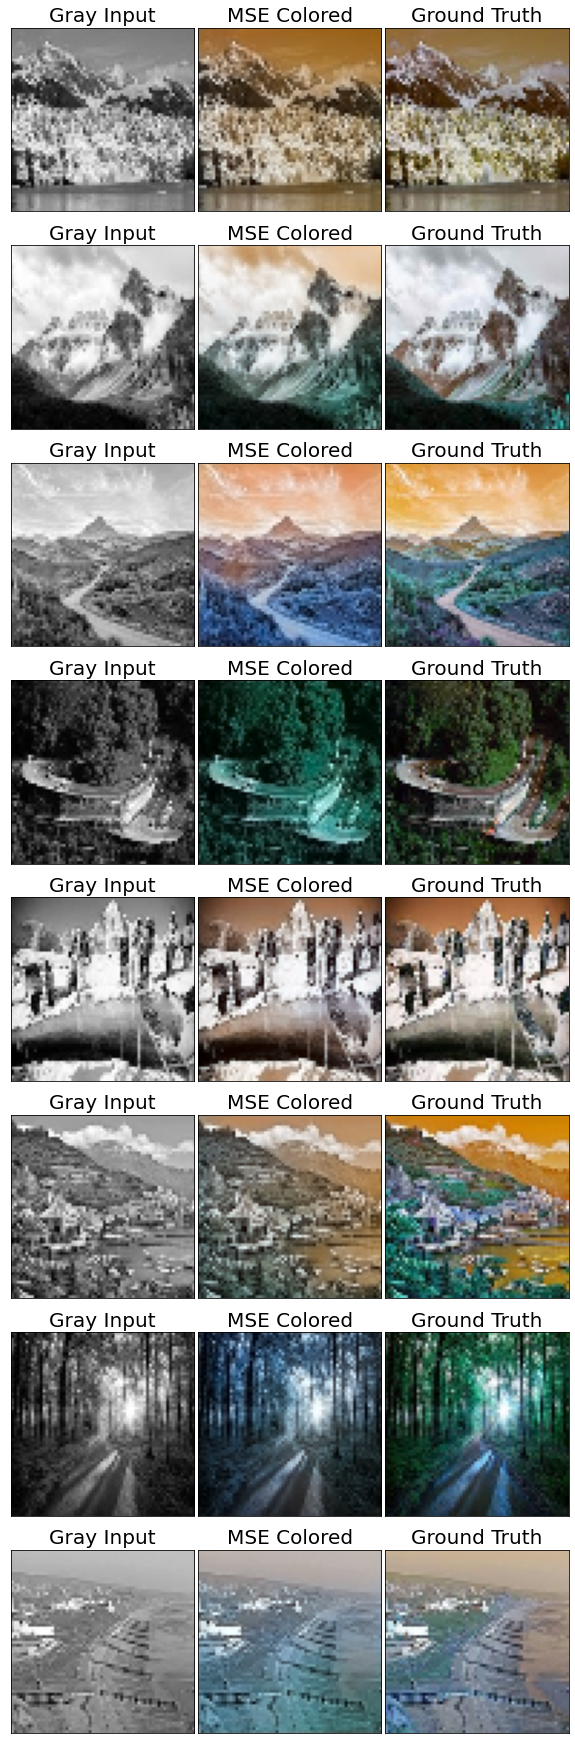

In [12]:
# Show results for batches of the validation set
for val_batch in range(2):
    val_images = utils.image_loader(directory='../images/val_images/',
        batch_size=8,training=False).__getitem__(val_batch)
    utils.display_images(gray_channel=val_images[0],color_channels=val_images[1],generator1=generator,gen1_title='MSE Colored');